In [1]:
# Import
import importlib
import dill
import random
import operator
import numpy as np
import torch
import models.predmissionnet as prednet
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

In [95]:
# Load the memory
with open('collect_samples_110000_memory_size_4_frames_300_missions_her_cpu_dense.pkl', 'rb') as file:
    mem = dill.load(file)
print("Memory loaded")

Memory loaded


In [96]:
random.shuffle(mem.memory)
train_memory = mem.memory[:100000]
test_memory = mem.memory[100000:110000]
#test_memory_with_good_mission = []
#for imc in test_memory:
#    if imc.target == 1:
#        test_memory_with_good_mission.append(imc)
        
# Skew ratio to sample the same amount of 0 and 1 
#train_targets = torch.cat(mem.imc(*zip(*train_memory)).target).cpu().numpy()
#idx_targets_corres = np.argwhere(train_targets == 1).reshape(-1)
#idx_targets_no_corres = np.argwhere(train_targets == 0).reshape(-1)

In [97]:
# memory dense
train_memory_dense = mem.memory_dense[:100000]
test_memory_dense = mem.memory_dense[100000:110000]
torch.cat(mem.imc_dense(*zip(*train_memory_dense)).target).numpy().mean()

0.38751

In [65]:
op = operator.itemgetter(*no_corres)
torch.cat(mem.imc(*zip(*op(train_memory))).target)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')

In [98]:
# Device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_types = 2
num_colors = 6
num_seniority = 5
num_size = 5
# List of all possible missions
missions_type = F.one_hot(torch.arange(num_types))
missions_color = F.one_hot(torch.arange(num_colors))
missions_seniority = F.one_hot(torch.arange(num_seniority))
missions_size = F.one_hot(torch.arange(num_size))

all_possible_missions = []
for i in range(missions_type.shape[0]):
    for j in range(missions_color.shape[0]):
        for k in range(missions_seniority.shape[0]):
            for l in range(missions_size.shape[0]):
                all_possible_missions.append(torch.cat((missions_type[i], missions_color[j], missions_seniority[k], missions_size[l])))
all_possible_missions = torch.stack(all_possible_missions, dim=0).to(device).float()

In [33]:
importlib.reload(prednet)

net = prednet.PredMissionNet(h=7, w=7, c=4, frames=1, lr_imc=5e-5,
                            dim_tokenizer=18, weight_decay=0).to(device)

#net = prednet.PredMissionOneHot(c=4, frames=1, n_type=num_types, n_color=num_colors, 
#                                n_seniority=num_seniority, n_size=num_size, lr=1e-5).to(device)

net = prednet.PredMissionOneHotDense(c=4, frames=1, n_type=num_types, n_color=num_colors, 
                                n_seniority=num_seniority, n_size=num_size, lr=1e-5).to(device)

#net.to(device)

In [99]:
use_imc = 0
use_onehot = 1

n_epochs = 1000
batch_size = 128
len_train = len(train_memory)
# Used for IMC
#len_test = len(test_memory_with_good_mission)
# For onehot
len_test = len(test_memory)

Start test time
Accuracy: 0.005
Start test time
Accuracy: 0.022
Start test time
Accuracy: 0.047
Start test time
Accuracy: 0.108
Start test time
Accuracy: 0.153
Start test time
Accuracy: 0.192
Start test time
Accuracy: 0.222
Start test time
Accuracy: 0.263
Start test time
Accuracy: 0.278
Start test time
Accuracy: 0.325
Start test time
Accuracy: 0.334
Start test time
Accuracy: 0.357
Start test time
Accuracy: 0.391
Start test time
Accuracy: 0.414
Start test time
Accuracy: 0.437
Start test time
Accuracy: 0.457
Start test time
Accuracy: 0.446
Start test time
Accuracy: 0.479
Start test time
Accuracy: 0.496
Start test time
Accuracy: 0.523
Start test time
Accuracy: 0.522
Start test time
Accuracy: 0.537
Start test time
Accuracy: 0.548
Start test time
Accuracy: 0.582
Start test time
Accuracy: 0.564
Start test time
Accuracy: 0.582
Start test time
Accuracy: 0.597
Start test time
Accuracy: 0.603
Start test time
Accuracy: 0.622
Start test time
Accuracy: 0.656
Start test time
Accuracy: 0.647
Start te

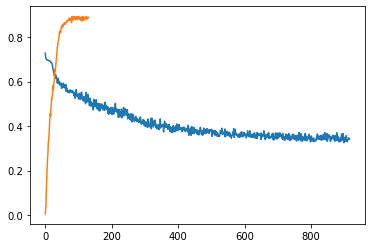

In [40]:
# Training procedure

losses = []
test_accs = np.array([])

for _ in range(n_epochs):
    beg_ind = 0
    end_ind = batch_size
    for i in range(len_train // batch_size):

        if use_imc:
            # Sample the same amount of 0 and 1
            batch_size_corres = batch_size // 2
            idx_corres = np.random.choice(idx_targets_corres, size=batch_size_corres)
            idx_no_corres = np.random.choice(idx_targets_no_corres, size=batch_size - batch_size_corres)
            op_corres = operator.itemgetter(*idx_corres)
            op_no_corres = operator.itemgetter(*idx_no_corres)
            imcs_corres = op_corres(train_memory)
            imcs_no_corres = op_no_corres(train_memory)
            imcs = imcs_corres + imcs_no_corres

        if use_onehot:
            imcs = train_memory[beg_ind:end_ind]

        batch_imcs = mem.imc(*zip(*imcs))
        batch_states = torch.cat(batch_imcs.state)
        # Keep only the last frame
        batch_states = batch_states[:, 12:].to(device)
        # For IMC only ! For onehot do not use batch mission
        if use_imc:
            batch_missions = torch.cat(batch_imcs.mission).to(device)
            batch_targets = torch.cat(batch_imcs.target).to(device)

        elif use_onehot:
            batch_targets = torch.cat(batch_imcs.target).to(device)
            batch_type_targets = batch_targets[:, :num_types]
            batch_type_targets = batch_type_targets.argmax(1)

            batch_color_targets = batch_targets[:, num_types: num_types + num_colors]
            batch_color_targets = batch_color_targets.argmax(1)

            batch_seniority_targets = batch_targets[:, num_types + num_colors:num_types + num_colors + num_seniority]
            batch_seniority_targets = batch_seniority_targets.argmax(1)

            batch_size_targets = batch_targets[:, num_types + num_colors + num_seniority:]
            batch_size_targets = batch_size_targets.argmax(1)

        if use_imc:
            batch_predictions = net.image_mission_correspondence(batch_states, batch_missions)

        if use_onehot:
            batch_type_predictions, batch_color_predictions, batch_seniority_predictions, batch_size_predictions = net(
                batch_states)

        if use_imc:
            loss = net.criterion(batch_predictions, batch_targets)
            net.optimizer_imc.zero_grad()
            loss.backward()
            net.optimizer_imc.step()

        elif use_onehot:
            net.optimizer.zero_grad()
            type_loss = net.criterion(batch_type_predictions, batch_type_targets)
            color_loss = net.criterion(batch_color_predictions, batch_color_targets)
            seniority_loss = net.criterion(batch_seniority_predictions, batch_seniority_targets)
            size_loss = net.criterion(batch_size_predictions, batch_size_targets)
            # loss = torch.sum([type_loss, color_loss, seniority_loss, size_loss])
            loss = sum([type_loss, color_loss, seniority_loss, size_loss])
            loss.backward()
            net.optimizer.step()

        beg_ind = end_ind
        end_ind += batch_size

        if i % 100 == 0:
            losses.append(float(loss))

    print("Start test time")

    if use_imc:
        batch_imcs = mem.imc(*zip(*test_memory_with_good_mission))
        batch_states = torch.cat(batch_imcs.state)[:, 12:].to(device)
        batch_missions = torch.cat(batch_imcs.mission).to(device)
        # Prediction of the missions
        batch_pred_missions = net.find_best_mission(batch_states, all_possible_missions)
        accuracy = torch.all(torch.eq(batch_pred_missions, batch_missions), dim=1)
        accuracy = accuracy.float().mean().cpu()
        test_accs = np.append(test_accs, accuracy)
        # Early stopping
        if test_accs.size > 100 and np.sum(test_accs[-50] < test_accs[-49:]) == 0:
            break
            
        print("Accuracy: {}".format(round(float(accuracy), 3)))

    elif use_onehot:
        batch_imcs = mem.imc(*zip(*test_memory))
        batch_states = torch.cat(batch_imcs.state)
        # Keep only the last frame
        batch_states = batch_states[:, 12:]
        
        # Predictions
        batch_type_predictions, batch_color_predictions, batch_seniority_predictions, batch_size_predictions = net.prediction(
            batch_states)
        
        batch_type_predictions_onehot = torch.eye(num_types)[batch_type_predictions]
        batch_color_predictions_onehot = torch.eye(num_colors)[batch_color_predictions]
        batch_seniority_predictions_onehot = torch.eye(num_seniority)[batch_seniority_predictions]
        batch_size_predictions_onehot = torch.eye(num_size)[batch_size_predictions]
        miss = (batch_type_predictions_onehot, batch_color_predictions_onehot, batch_seniority_predictions_onehot, batch_size_predictions_onehot)
        batch_mission_predictions = torch.cat(miss, dim=1).to(device)
        
        # Targets
        batch_targets = torch.cat(batch_imcs.target).to(device)
        batch_type_targets = batch_targets[:, :num_types].max(1)[1]
        batch_color_targets = batch_targets[:, num_types:num_types + num_colors].max(1)[1]
        batch_seniority_targets = batch_targets[:, num_types + num_colors:num_types + num_colors + num_seniority].max(1)[1]
        batch_size_targets = batch_targets[:, num_types + num_colors + num_seniority:].max(1)[1]
        
        # Compute accuracies
        acc_type = float(torch.eq(batch_type_predictions, batch_type_targets).sum()) / len(test_memory)
        acc_color = float(torch.eq(batch_color_predictions, batch_color_targets).sum()) / len(test_memory)
        acc_seniority = float(torch.eq(batch_seniority_predictions, batch_seniority_targets).sum()) / len(test_memory)
        acc_size = float(torch.eq(batch_size_predictions, batch_size_targets).sum()) / len(test_memory)
        acc_total = float(torch.all(torch.eq(batch_mission_predictions, batch_targets), dim=1).sum()) / len(test_memory)
        test_accs = np.append(test_accs, acc_total)
        # Early stopping
        if test_accs.size > 100 and np.sum(test_accs[-50] < test_accs[-49:]) == 0:
            print("Early stopping with accuracy {}".format(acc_total))
            break
        print(
            "Acc total {}, Acc type: {}, Acc color {}, Acc seniority {}, Acc size {}".format(round(acc_total, 3), round(acc_type, 3), round(acc_color, 3),
                                                                               round(acc_seniority, 3),
                                                                               round(acc_size, 3)))

plt.plot(losses)
plt.plot(test_accs)
plt.show()

# DENSE TRAINING

In [104]:
importlib.reload(prednet)

#net = prednet.PredMissionNet(h=7, w=7, c=4, frames=1, lr_imc=5e-5,
#                            dim_tokenizer=18, weight_decay=0).to(device)

#net = prednet.PredMissionOneHot(c=4, frames=1, n_type=num_types, n_color=num_colors, 
#                                n_seniority=num_seniority, n_size=num_size, lr=1e-5).to(device)

net = prednet.PredMissionOneHotDense(c=4, frames=1, n_type=num_types, n_color=num_colors, 
                                n_seniority=num_seniority, n_size=num_size, lr=5e-5).to(device)

#net.to(device)

In [105]:
# Training procedure

losses = []
test_accs = np.array([])

for _ in range(n_epochs):
    beg_ind = 0
    end_ind = batch_size
    for i in range(len_train // batch_size):

        if use_imc:
            # Sample the same amount of 0 and 1
            batch_size_corres = batch_size // 2
            idx_corres = np.random.choice(idx_targets_corres, size=batch_size_corres)
            idx_no_corres = np.random.choice(idx_targets_no_corres, size=batch_size - batch_size_corres)
            op_corres = operator.itemgetter(*idx_corres)
            op_no_corres = operator.itemgetter(*idx_no_corres)
            imcs_corres = op_corres(train_memory)
            imcs_no_corres = op_no_corres(train_memory)
            imcs = imcs_corres + imcs_no_corres

        if use_onehot:
            imcs = train_memory[beg_ind:end_ind]
            imcs_dense = train_memory_dense[beg_ind:end_ind]
        
        batch_imcs_dense = mem.imc_dense(*zip(*imcs_dense))
        batch_imcs = mem.imc(*zip(*imcs))
        batch_states = torch.cat(batch_imcs.state)
        batch_states_dense = torch.cat(batch_imcs_dense.state)
        # Keep only the last frame
        batch_states = batch_states[:, 12:].to(device)
        batch_states_dense = batch_states_dense[:, 12:].to(device)
        # For IMC only ! For onehot do not use batch mission
        if use_imc:
            batch_missions = torch.cat(batch_imcs.mission).to(device)
            batch_targets = torch.cat(batch_imcs.target).to(device)

        elif use_onehot:
            batch_targets = torch.cat(batch_imcs.target).to(device)
            batch_type_targets = batch_targets[:, :num_types]
            batch_type_targets = batch_type_targets.argmax(1)

            batch_color_targets = batch_targets[:, num_types: num_types + num_colors]
            batch_color_targets = batch_color_targets.argmax(1)

            batch_seniority_targets = batch_targets[:, num_types + num_colors:num_types + num_colors + num_seniority]
            batch_seniority_targets = batch_seniority_targets.argmax(1)

            batch_size_targets = batch_targets[:, num_types + num_colors + num_seniority:]
            batch_size_targets = batch_size_targets.argmax(1)
            
            # Dense
            batch_dense_targets = torch.cat(batch_imcs_dense.target).to(device)
            
            

        if use_imc:
            batch_predictions = net.image_mission_correspondence(batch_states, batch_missions)

        if use_onehot:
            batch_type_predictions, batch_color_predictions, batch_seniority_predictions, batch_size_predictions, batch_dense_predictions = net(
                batch_states)
            #print(batch_dense_predictions)

        if use_imc:
            loss = net.criterion(batch_predictions, batch_targets)
            net.optimizer_imc.zero_grad()
            loss.backward()
            net.optimizer_imc.step()

        elif use_onehot:
            net.optimizer.zero_grad()
            #type_loss = net.criterion(batch_type_predictions, batch_type_targets)
            #color_loss = net.criterion(batch_color_predictions, batch_color_targets)
            #seniority_loss = net.criterion(batch_seniority_predictions, batch_seniority_targets)
            #size_loss = net.criterion(batch_size_predictions, batch_size_targets)
            dense_loss = net.criterion_dense(batch_dense_predictions, batch_dense_targets)
            # loss = torch.sum([type_loss, color_loss, seniority_loss, size_loss])
            #loss = sum([type_loss, color_loss, seniority_loss, size_loss, dense_loss])
            loss = dense_loss
            loss.backward()
            net.optimizer.step()

        beg_ind = end_ind
        end_ind += batch_size

        if i % 100 == 0:
            losses.append(float(loss))

    print("Start test time")

    if use_imc:
        batch_imcs = mem.imc(*zip(*test_memory_with_good_mission))
        batch_states = torch.cat(batch_imcs.state)[:, 12:].to(device)
        batch_missions = torch.cat(batch_imcs.mission).to(device)
        # Prediction of the missions
        batch_pred_missions = net.find_best_mission(batch_states, all_possible_missions)
        accuracy = torch.all(torch.eq(batch_pred_missions, batch_missions), dim=1)
        accuracy = accuracy.float().mean().cpu()
        test_accs = np.append(test_accs, accuracy)
        # Early stopping
        if test_accs.size > 100 and np.sum(test_accs[-50] < test_accs[-49:]) == 0:
            break
            
        print("Accuracy: {}".format(round(float(accuracy), 3)))

    elif use_onehot:
        batch_imcs = mem.imc(*zip(*test_memory))
        batch_imcs_dense = mem.imc_dense(*zip(*test_memory_dense))
        batch_states = torch.cat(batch_imcs.state)
        batch_states_dense = torch.cat(batch_imcs_dense.state)
        # Keep only the last frame
        batch_states = batch_states[:, 12:].to(device)
        batch_states_dense = batch_states[:, 12:].to(device)
        
        # Predictions
        batch_type_predictions, batch_color_predictions, batch_seniority_predictions, batch_size_predictions, batch_dense_predictions = net.prediction(
            batch_states)
        
        batch_type_predictions_onehot = torch.eye(num_types)[batch_type_predictions]
        batch_color_predictions_onehot = torch.eye(num_colors)[batch_color_predictions]
        batch_seniority_predictions_onehot = torch.eye(num_seniority)[batch_seniority_predictions]
        batch_size_predictions_onehot = torch.eye(num_size)[batch_size_predictions]
        miss = (batch_type_predictions_onehot, batch_color_predictions_onehot, batch_seniority_predictions_onehot, batch_size_predictions_onehot)
        batch_mission_predictions = torch.cat(miss, dim=1).to(device)
        
        # Targets
        batch_targets = torch.cat(batch_imcs.target).to(device)
        batch_type_targets = batch_targets[:, :num_types].max(1)[1]
        batch_color_targets = batch_targets[:, num_types:num_types + num_colors].max(1)[1]
        batch_seniority_targets = batch_targets[:, num_types + num_colors:num_types + num_colors + num_seniority].max(1)[1]
        batch_size_targets = batch_targets[:, num_types + num_colors + num_seniority:].max(1)[1]
        batch_dense_targets = torch.cat(batch_imcs_dense.target).to(device)
        
        # Compute accuracies
        acc_type = float(torch.eq(batch_type_predictions, batch_type_targets).sum()) / len(test_memory)
        acc_color = float(torch.eq(batch_color_predictions, batch_color_targets).sum()) / len(test_memory)
        acc_seniority = float(torch.eq(batch_seniority_predictions, batch_seniority_targets).sum()) / len(test_memory)
        acc_size = float(torch.eq(batch_size_predictions, batch_size_targets).sum()) / len(test_memory)
        acc_total = float(torch.all(torch.eq(batch_mission_predictions, batch_targets), dim=1).sum()) / len(test_memory)
        test_accs = np.append(test_accs, acc_total)
        acc_dense = float(torch.eq(batch_dense_predictions, batch_dense_targets).sum()) / len(test_memory_dense)
        # Early stopping
        #if test_accs.size > 100 and np.sum(test_accs[-50] < test_accs[-49:]) == 0:
        #    print("Early stopping with accuracy {}".format(acc_total))
        #    break
        print(
            "Acc dense {}, Acc total {}, Acc type: {}, Acc color {}, Acc seniority {}, Acc size {}".format(round(acc_dense, 3), round(acc_total, 3), round(acc_type, 3), round(acc_color, 3),
                                                                               round(acc_seniority, 3),
                                                                               round(acc_size, 3)))

plt.plot(losses)
plt.plot(test_accs)
plt.show()

Start test time
Acc dense 0.591, Acc total 0.004, Acc type: 0.5, Acc color 0.17, Acc seniority 0.202, Acc size 0.197
Start test time
Acc dense 0.596, Acc total 0.004, Acc type: 0.5, Acc color 0.171, Acc seniority 0.202, Acc size 0.197
Start test time
Acc dense 0.597, Acc total 0.004, Acc type: 0.5, Acc color 0.17, Acc seniority 0.202, Acc size 0.197
Start test time
Acc dense 0.597, Acc total 0.004, Acc type: 0.5, Acc color 0.17, Acc seniority 0.202, Acc size 0.197
Start test time
Acc dense 0.598, Acc total 0.004, Acc type: 0.5, Acc color 0.171, Acc seniority 0.202, Acc size 0.197
Start test time
Acc dense 0.597, Acc total 0.004, Acc type: 0.5, Acc color 0.171, Acc seniority 0.202, Acc size 0.197
Start test time
Acc dense 0.597, Acc total 0.004, Acc type: 0.5, Acc color 0.171, Acc seniority 0.202, Acc size 0.197
Start test time
Acc dense 0.594, Acc total 0.004, Acc type: 0.5, Acc color 0.171, Acc seniority 0.202, Acc size 0.198
Start test time
Acc dense 0.592, Acc total 0.004, Acc type:

KeyboardInterrupt: 

In [46]:
torch.cat(batch_imcs_dense.target).to(device)

tensor([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
        0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')

In [60]:
test_memory_dense[0].state[:, 12:]

tensor([[[[2., 2., 2., 2., 2., 2., 2.],
          [2., 2., 2., 2., 2., 2., 2.],
          [2., 2., 2., 2., 2., 1., 1.],
          [2., 2., 2., 2., 2., 1., 1.],
          [2., 2., 2., 2., 2., 1., 1.],
          [2., 2., 2., 2., 2., 6., 1.],
          [2., 2., 2., 2., 2., 1., 1.]],

         [[5., 5., 5., 5., 5., 5., 5.],
          [5., 5., 5., 5., 5., 5., 5.],
          [5., 5., 5., 5., 5., 0., 0.],
          [5., 5., 5., 5., 5., 0., 0.],
          [5., 5., 5., 5., 5., 0., 0.],
          [5., 5., 5., 5., 5., 0., 0.],
          [5., 5., 5., 5., 5., 0., 0.]],

         [[0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 2., 0.],
          [0., 0., 0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0.,

In [41]:
batch_dense_predictions

tensor([[ 0.2236, -0.2969],
        [ 0.3312, -0.2582],
        [ 0.3313, -0.1681],
        [ 0.4006, -0.0939],
        [ 0.3696, -0.0869],
        [ 0.3220, -0.2165],
        [ 0.2476, -0.2257],
        [ 0.3503, -0.1430],
        [ 0.2323, -0.1439],
        [ 0.3043, -0.1529],
        [ 0.3390, -0.1293],
        [ 0.3391, -0.2115],
        [ 0.1979, -0.1770],
        [ 0.3529, -0.1965],
        [ 0.3406, -0.1687],
        [ 0.3015, -0.2478],
        [ 0.2688, -0.1446],
        [ 0.3138, -0.2099],
        [ 0.2860, -0.1931],
        [ 0.2651, -0.1799],
        [ 0.2582, -0.2007],
        [ 0.3743, -0.1731],
        [ 0.2376, -0.2513],
        [ 0.2525, -0.1178],
        [ 0.2241, -0.0969],
        [ 0.2237, -0.1383],
        [ 0.3307, -0.0723],
        [ 0.2714, -0.1279],
        [ 0.3349, -0.1451],
        [ 0.3497, -0.0747],
        [ 0.2980, -0.1694],
        [ 0.3548, -0.1004],
        [ 0.3313, -0.0731],
        [ 0.2717, -0.2179],
        [ 0.3009, -0.1211],
        [ 0.2196, -0

In [23]:
a = torch.ones(5,2)
b = torch.ones(5, 4)
torch.cat((a,b), dim=1).shape

torch.Size([5, 6])

In [62]:
batch_imcs = mem.imc(*zip(*test_memory))
batch_states = torch.cat(batch_imcs.state)
# Keep only the last frame
batch_states = batch_states[:, 12:]
        
# Predictions
batch_type_predictions, batch_color_predictions, batch_seniority_predictions, batch_size_predictions = net.prediction(
    batch_states)
        
batch_type_predictions_onehot = torch.eye(num_types)[batch_type_predictions]
batch_color_predictions_onehot = torch.eye(num_colors)[batch_color_predictions]
batch_seniority_predictions_onehot = torch.eye(num_seniority)[batch_seniority_predictions]
batch_size_predictions_onehot = torch.eye(num_size)[batch_size_predictions]
miss = (batch_type_predictions_onehot, batch_color_predictions_onehot, batch_seniority_predictions_onehot, batch_size_predictions_onehot)
batch_mission_predictions = torch.cat(miss, dim=1).to(device)
        
# Targets
batch_targets = torch.cat(batch_imcs.target).to(device)
batch_type_targets = batch_targets[:, :num_types].max(1)[1]
batch_color_targets = batch_targets[:, num_types:num_types + num_colors].max(1)[1]
batch_seniority_targets = batch_targets[:, num_types + num_colors:num_types + num_colors + num_seniority].max(1)[1]
batch_size_targets = batch_targets[:, num_types + num_colors + num_seniority:].max(1)[1]
        
# Compute accuracies
acc_type = float(torch.eq(batch_type_predictions, batch_type_targets).sum()) / len(test_memory)
acc_color = float(torch.eq(batch_color_predictions, batch_color_targets).sum()) / len(test_memory)
acc_seniority = float(torch.eq(batch_seniority_predictions, batch_seniority_targets).sum()) / len(test_memory)
acc_size = float(torch.eq(batch_size_predictions, batch_size_targets).sum()) / len(test_memory)
acc_total = float(torch.all(torch.eq(batch_mission_predictions, batch_targets), dim=1).sum()) / len(test_memory)


In [65]:
torch.eq(batch_seniority_predictions, batch_seniority_targets).shape

torch.Size([10])

In [40]:
a = torch.tensor([[1,0], [0, 1]])
b = torch.tensor([[1,0], [1, 0]])

In [44]:
torch.eq(a, b)

tensor([[1, 1],
        [0, 0]], dtype=torch.uint8)

In [43]:
torch.all(torch.eq(a, b), dim=1)

tensor([1, 0], dtype=torch.uint8)

In [58]:
imc = test_memory[0]
imc.state[0,12:]

tensor([[[2., 2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 1., 1., 1.],
         [2., 2., 2., 2., 5., 1., 1.],
         [2., 2., 2., 2., 1., 5., 1.],
         [2., 2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2., 2.]],

        [[5., 5., 5., 5., 5., 5., 5.],
         [5., 5., 5., 5., 0., 0., 0.],
         [5., 5., 5., 5., 0., 0., 0.],
         [5., 5., 5., 5., 0., 3., 0.],
         [5., 5., 5., 5., 5., 5., 5.],
         [5., 5., 5., 5., 5., 5., 5.],
         [5., 5., 5., 5., 5., 5., 5.]]], device='cuda:0')

In [12]:
def order_mission(net, state, missions):
    # Note: state [1, x] and missions [n, y]
    embedded_state = net.embedding_image(state.repeat(missions.shape[0], 1, 1, 1)).detach()
    embedded_missions = net.embedding_mission(missions).detach()
    distances = F.pairwise_distance(embedded_state, embedded_missions)
    indices_best_missions = torch.argsort(distances, descending=False)
    sorted_distances = torch.sort(distances)
    return sorted_distances, missions[indices_best_missions]

In [108]:
order_mission(net, test_memory[15].state[:, 6:], all_possible_missions)

(torch.return_types.sort(
 values=tensor([0.2873, 0.3829, 1.2301, 1.2590, 1.5581, 1.6134, 1.9446, 1.9797],
        device='cuda:0'),
 indices=tensor([6, 7, 5, 3, 4, 2, 0, 1], device='cuda:0')),
 tensor([[0., 1., 0., 0., 1., 0.],
         [0., 1., 0., 0., 0., 1.],
         [0., 1., 0., 1., 0., 0.],
         [1., 0., 0., 0., 0., 1.],
         [0., 1., 1., 0., 0., 0.],
         [1., 0., 0., 0., 1., 0.],
         [1., 0., 1., 0., 0., 0.],
         [1., 0., 0., 1., 0., 0.]], device='cuda:0'))

In [56]:
test_memory_with_good_mission[3].state[:, 6:]

tensor([[[[2., 2., 2., 2., 2., 2., 2.],
          [2., 2., 2., 2., 2., 1., 1.],
          [2., 2., 2., 2., 2., 6., 1.],
          [2., 2., 2., 2., 2., 5., 1.],
          [2., 2., 2., 2., 2., 2., 2.],
          [2., 2., 2., 2., 2., 2., 2.],
          [2., 2., 2., 2., 2., 2., 2.]],

         [[5., 5., 5., 5., 5., 5., 5.],
          [5., 5., 5., 5., 5., 0., 0.],
          [5., 5., 5., 5., 5., 2., 0.],
          [5., 5., 5., 5., 5., 3., 0.],
          [5., 5., 5., 5., 5., 5., 5.],
          [5., 5., 5., 5., 5., 5., 5.],
          [5., 5., 5., 5., 5., 5., 5.]]]], device='cuda:0')

In [58]:
for imc in test_memory_with_good_mission[3:10]:
    state = imc.state[:, 6:]
    true_mission = torch.squeeze(imc.mission, dim=0)
    prediction_mission = net.find_best_mission(state, all_possible_missions)
    #print("pred mission {}".format(prediction_mission))
    print("pred mission {} \n true mission {}".format(prediction_mission, true_mission))

pred mission tensor([0., 1., 0., 0., 0., 1.], device='cuda:0') 
 true mission tensor([0., 1., 0., 0., 1., 0.], device='cuda:0')
pred mission tensor([1., 0., 0., 0., 0., 1.], device='cuda:0') 
 true mission tensor([0., 1., 1., 0., 0., 0.], device='cuda:0')
pred mission tensor([1., 0., 0., 0., 0., 1.], device='cuda:0') 
 true mission tensor([0., 1., 0., 1., 0., 0.], device='cuda:0')
pred mission tensor([1., 0., 0., 0., 1., 0.], device='cuda:0') 
 true mission tensor([0., 1., 1., 0., 0., 0.], device='cuda:0')
pred mission tensor([1., 0., 0., 0., 0., 1.], device='cuda:0') 
 true mission tensor([0., 1., 1., 0., 0., 0.], device='cuda:0')
pred mission tensor([0., 1., 0., 1., 0., 0.], device='cuda:0') 
 true mission tensor([1., 0., 0., 0., 1., 0.], device='cuda:0')
pred mission tensor([1., 0., 0., 1., 0., 0.], device='cuda:0') 
 true mission tensor([0., 1., 0., 0., 1., 0.], device='cuda:0')


In [28]:
test_memory_with_good_mission = []
for imc in test_memory:
    if imc.target == 1:
        test_memory_with_good_mission.append(imc)

In [29]:
len(test_memory_with_good_mission)

565

In [35]:
acc = 0
for imc in test_memory_with_good_mission:
    state = imc.state[:, 6:]
    true_mission = torch.squeeze(imc.mission, dim=0)
    prediction_mission = net.find_best_mission(state, all_possible_missions)
    acc += torch.equal(prediction_mission, true_mission)
acc /= 565
print("Accuracy: {}".format(acc))

Accuracy: 0.9575221238938053


In [33]:
for i in range(20):
    print(test_memory_with_good_mission[i].target)

tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
